In [1]:
# 根据类别分类来生成姓名

In [31]:
import torch

# 选择cpu or gpu
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [33]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # 增加 EOS 标记

def findFiles(path): return glob.glob(path)

# 将unicode转化为Ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 阅读文件并按行读取
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# 根据姓名和类别创建字典
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


In [35]:
import torch
import torch.nn as nn
# 每个时间步预测当前字母的下一个字母，
# 因此字母对是姓名中连续字母的组合——例如，对于 "ABCD<EOS>"，我们将创建（“A”，“B”），（“B”，“C”），（“C”，“D”），（“D”，“EOS”）对。
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size) # [category, current letter, hidden state]
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size) # [next letter, next hidden state]
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [37]:
import random

# 随机生成数字列表
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 随机获取一个类别和名字
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [41]:
# One-hot vector for category->类别列表转为tensor
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input -> 输入名字转为tensor 不包含EOS
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target -> 输入名字转为tensor 包含EOS
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [67]:
# Make category, input, and target tensors from a random category, line pair ->  随机产生一个<类别，姓名>对
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category).to(device)
    input_line_tensor = inputTensor(line).to(device)
    target_line_tensor = targetTensor(line).to(device)
    return category_tensor, input_line_tensor, target_line_tensor

In [69]:
# 在训练循环外定义一次（通常在模型初始化后）
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [71]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden().to(device)

    optimizer.zero_grad()  

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden) #例如Tom 输入为["T","o"]
        l = criterion(output, target_line_tensor[i]) # 这里的输入为["o","m","EOS"]
        loss += l

    loss.backward()

    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [73]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [75]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000 # 总训练次数
print_every = 5000 #每5000次打印一次
plot_every = 500 #每500次记录一次用于画图
all_losses = [] #记录所有画图所需的损失
total_loss = 0 

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 48s (5000 5%) 4.0457
1m 35s (10000 10%) 4.1134
2m 22s (15000 15%) 4.0424
3m 9s (20000 20%) 4.0481
3m 55s (25000 25%) 4.1046
4m 46s (30000 30%) 4.0513
5m 37s (35000 35%) 4.0767
6m 22s (40000 40%) 4.1157
7m 8s (45000 45%) 4.0929
7m 54s (50000 50%) 4.0425
8m 42s (55000 55%) 4.0984
9m 28s (60000 60%) 4.0130
10m 13s (65000 65%) 4.0697
10m 57s (70000 70%) 4.0763
11m 45s (75000 75%) 4.0630
12m 32s (80000 80%) 4.0704
13m 21s (85000 85%) 4.0423
14m 8s (90000 90%) 4.0888
14m 59s (95000 95%) 4.0612
15m 50s (100000 100%) 4.0472


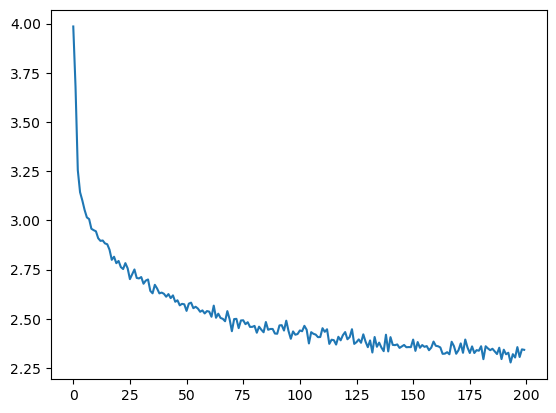

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [23]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Roulov
Uanterov
Shavantov
Geren
Eren
Roure
Santaro
Pare
Alara
Chan
Han
Iua
